In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../DATA/kc_house_data.csv")

In [2]:
# df.info()
# df.describe().transpose()

C:\Users\42060\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

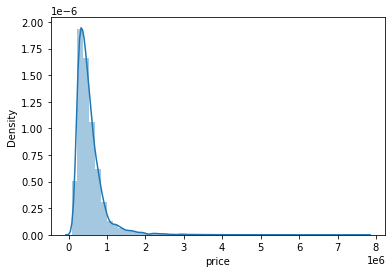

In [4]:
# sns.distplot(df['price'])

<AxesSubplot:>

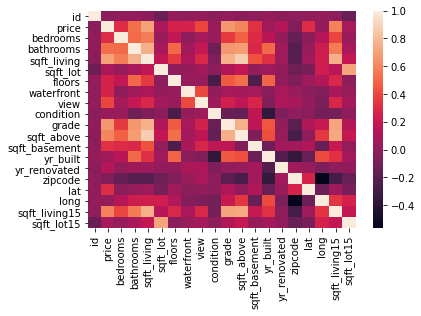

In [5]:
sns.heatmap(df.corr())

In [6]:
df.corr()['price'].sort_values()

zipcode         -0.053402
id              -0.016772
long             0.022036
condition        0.036056
yr_built         0.053953
sqft_lot15       0.082845
sqft_lot         0.089876
yr_renovated     0.126424
floors           0.256804
waterfront       0.266398
lat              0.306692
bedrooms         0.308787
sqft_basement    0.323799
view             0.397370
bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
grade            0.667951
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

In [136]:
# print(df.apply(lambda col: col.unique()))

<AxesSubplot:xlabel='waterfront', ylabel='price'>

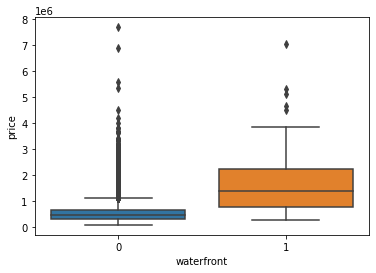

In [8]:
sns.boxplot(x='waterfront', y='price', data=df)

In [1]:
# sns.scatterplot(x='long',y='lat',hue='price',data=df)

In [10]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)
df['month'] = df['date'].apply(lambda date: date.month)

In [11]:
df = df.drop(['id','zipcode','date'],axis=1)

In [13]:
# vyřazení outlierů - cena nad 4 mil.
df = df[df["price"] <= 4000000]

In [14]:
# Dummy proměnné pro rok a měsíc
df_dummy = df
df_dummy['year'] = df['year'].apply(str)
df_dummy['month'] = df['month'].apply(str)
df_dummy = pd.get_dummies(data=df_dummy)

In [15]:
# interakční člen pro lat a long
df_dummy["lat_long"] = df['lat']*df["long"]

# Model

# Grid search

In [41]:
X = df.drop('price',axis=1)
y = df['price']

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler_grid_search = MinMaxScaler().fit(X)
X_grid_search = scaler_grid_search.transform(X)

In [73]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

In [74]:
def create_model(activation,neurons):
    model = Sequential()

    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))

    model.compile(loss='MSE', optimizer='adam')
    
    return model

In [75]:
model = KerasRegressor(build_fn=create_model)

In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
neg_MSE_scorer = make_scorer(mean_squared_error,greater_is_better=False)

param_grid = dict(
                    epochs = [400], #range(100,500,50), 
                    batch_size = [32, 64, 128], #range(90,90,200),
                    neurons = [19,38],
                    activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
                    
#                     learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#                     momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#                     init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

#                     weight_constraint = [1, 2, 3, 4, 5]
#                     dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
                  )

grid = GridSearchCV(estimator=model, scoring=neg_MSE_scorer, param_grid=param_grid, n_jobs=-1, cv=3)

In [3]:
grid_result = grid.fit(X_grid_search, y.values)

In [81]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -22566517426.277161 using {'activation': 'relu', 'batch_size': 64, 'epochs': 400, 'neurons': 38}
-410663998038.885498 (22821671228.258419) with: {'activation': 'softmax', 'batch_size': 64, 'epochs': 400, 'neurons': 19}
-410663631575.412048 (22821636749.295277) with: {'activation': 'softmax', 'batch_size': 64, 'epochs': 400, 'neurons': 38}
-410759756637.682556 (22823882307.361702) with: {'activation': 'softmax', 'batch_size': 128, 'epochs': 400, 'neurons': 19}
-410759530244.654236 (22823944098.894146) with: {'activation': 'softmax', 'batch_size': 128, 'epochs': 400, 'neurons': 38}
-28319750409.132092 (2703698802.171873) with: {'activation': 'softplus', 'batch_size': 64, 'epochs': 400, 'neurons': 19}
-28032443084.715771 (2691508704.704962) with: {'activation': 'softplus', 'batch_size': 64, 'epochs': 400, 'neurons': 38}
-29231663192.573944 (3153900032.567221) with: {'activation': 'softplus', 'batch_size': 128, 'epochs': 400, 'neurons': 19}
-28918756960.823925 (2940728186.322831) wit

# Final Model

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [26]:
scaler = MinMaxScaler().fit(X_train)

In [31]:
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [93]:
model_final = Sequential()

model_final.add(Dense(38,activation='relu'))
model_final.add(Dense(38,activation='relu'))
model_final.add(Dense(38,activation='relu'))
model_final.add(Dense(38,activation='relu'))
model_final.add(Dense(1))

model_final.compile(optimizer='adam',loss='mse')

In [4]:
model_final.fit(x=X_train_norm,y=y_train.values,
              validation_data=(X_test_norm,y_test.values),
              batch_size=64,epochs=2000)

In [95]:
losses = pd.DataFrame(model_final.history.history)

<AxesSubplot:>

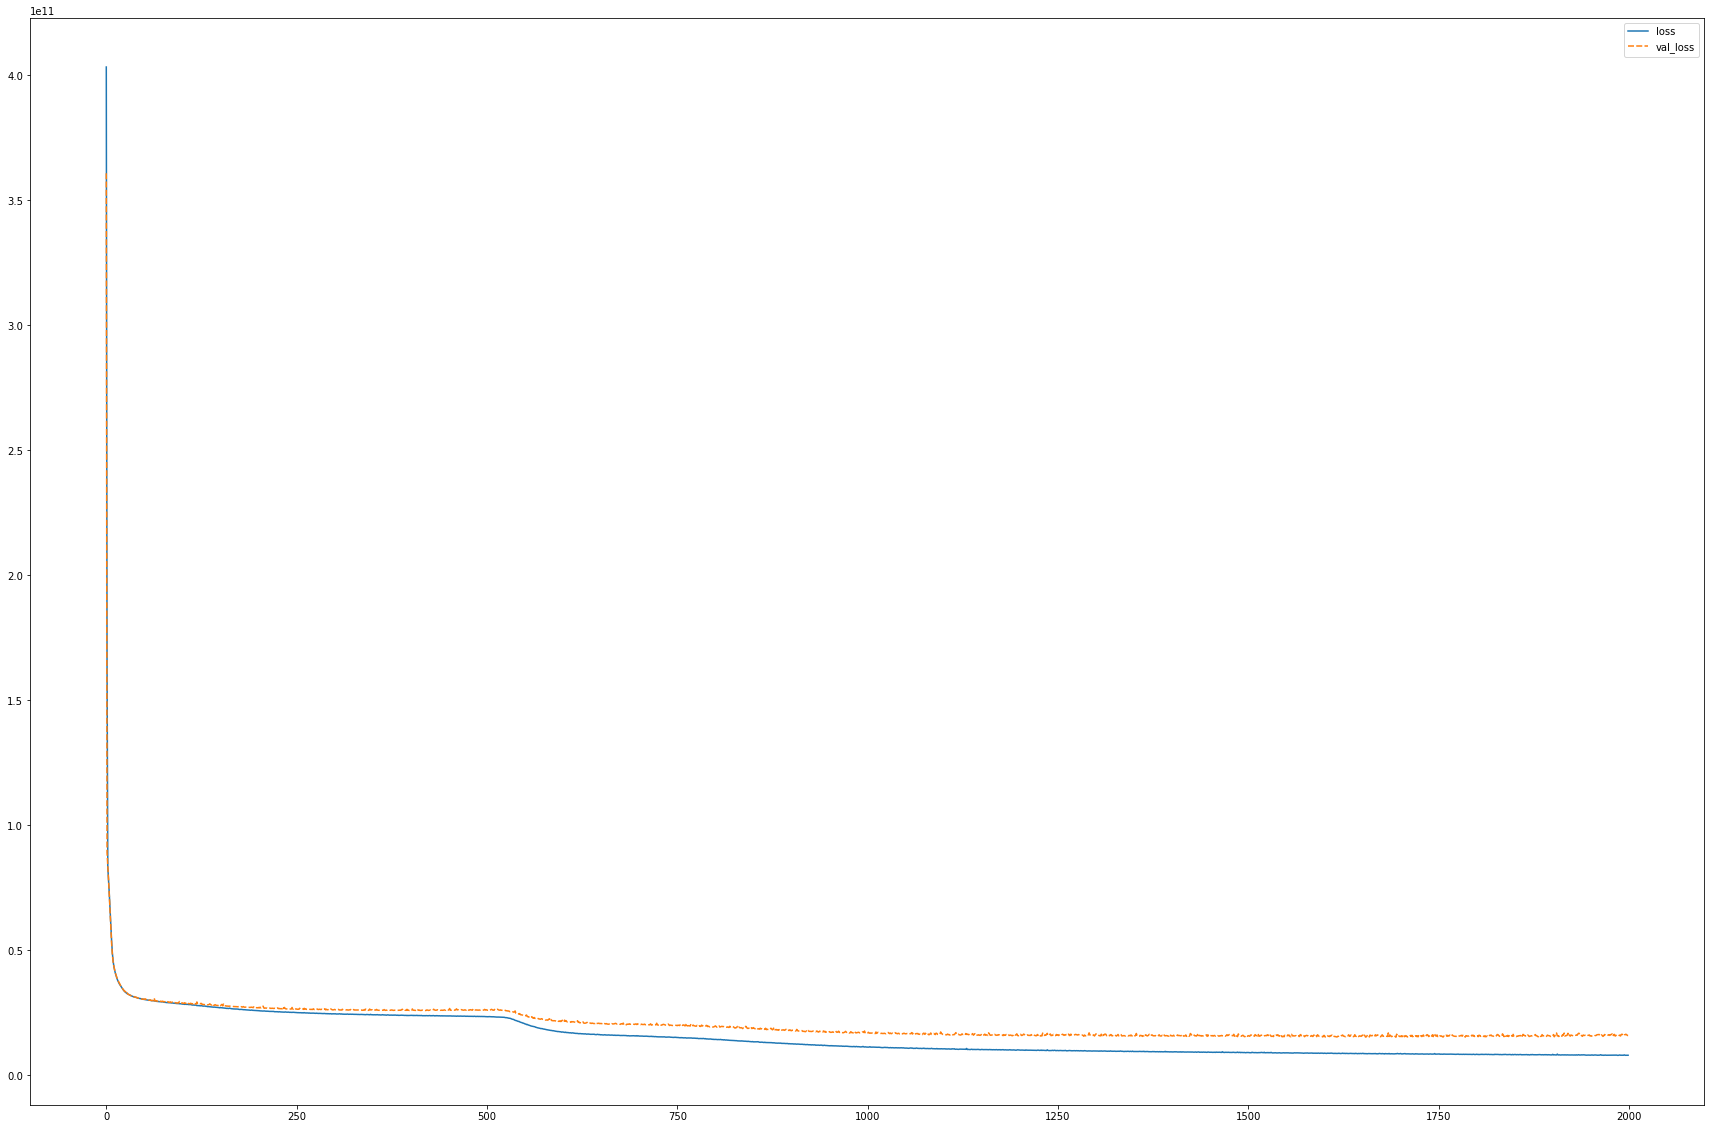

In [97]:
plt.figure(figsize=(30,20))
sns.lineplot(data=losses)

# Evaluation

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [100]:
preds = model_final.predict(X_test_norm)

print("MSE_sqrt",np.sqrt(mean_squared_error(y_test,preds)))
print("MAE",mean_absolute_error(y_test,preds))
print("R2",r2_score(y_test,preds))

MSE_sqrt 125866.18293066634
MAE 70309.23611942171
R2 0.8728477034830839


In [117]:
y_test_DF = pd.DataFrame(y_test.values)
preds_DF = pd.DataFrame(preds)

In [123]:
preds_DF.values

array([[244661.64],
       [574815.75],
       [503987.47],
       ...,
       [882754.6 ],
       [352462.7 ],
       [643533.7 ]], dtype=float32)

In [118]:
residuals = y_test_DF - preds_DF

C:\Users\42060\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

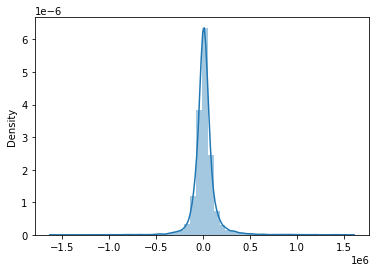

In [120]:
sns.distplot(residuals)

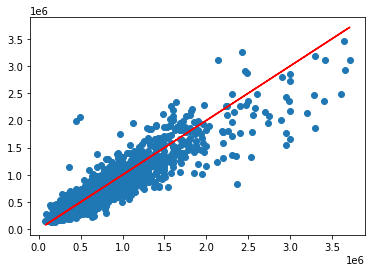

In [135]:
plt.scatter(y_test_DF.values,preds_DF.values)
plt.plot(y_test_DF.values,y_test_DF.values,'r')